# 门控循环单元（GRU）

In [7]:
import os
import re
import hashlib
import urllib.request
import collections


DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    import random

    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [1]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [2]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [4]:
# 加载torch
import torch.nn.functional as F
from torch import nn
class RNNModel(nn.Module):  #@save
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        # 现在不用太在意
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, input, output):
        X = F.one_hot(input.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, output)
        # Y相当于每一个时间步的state，而state是最后一个时间步的状态。
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [5]:
import torch
import torch.nn as nn
import math
import time
import matplotlib.pyplot as plt

# ==================================================================
# 1. 必需的辅助函数 (替代 d2l 的功能)
# ==================================================================

def grad_clipping(net, theta):
    """裁剪梯度 (使用PyTorch内置函数实现)"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
        torch.nn.utils.clip_grad_norm_(params, theta)

def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    # 将网络设置为评估模式
    net.eval()
    # 初始化隐藏状态
    state = net.begin_state(batch_size=1, device=device)
    # 将前缀文本转换为数字索引
    outputs = [vocab[prefix[0]]]
    # 预热阶段：用前缀来更新隐藏状态
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    # 预测阶段：生成 num_preds 个新字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        
    # 将生成的数字索引转换回文本
    return ''.join([vocab.to_tokens(i) for i in outputs])

# ==================================================================
# 2. 合并后的主训练函数
# ==================================================================

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
                         use_random_iter=False):
    """
    训练语言模型 (不依赖d2l库的整合版本)

    :param net: 神经网络模型 (nn.Module)
    :param train_iter: 训练数据迭代器
    :param vocab: 词汇表对象
    :param lr: 学习率
    :param num_epochs: 训练周期数
    :param device: 训练设备 (cpu, cuda, mps)
    :param use_random_iter: 是否使用随机采样迭代器
    """
    # --- 初始化 ---
    print(f"开始在 {device} 上训练...")
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr)
    
    # 用于存储每个epoch的困惑度，以供最后绘图
    history = []

    # --- 训练循环 ---
    for epoch in range(num_epochs):
        # --- 单个迭代周期的逻辑 (原 train_epoch_ch8) ---
        state, timer_start = None, time.time()
        
        # 替代 d2l.Accumulator
        total_loss = 0.0
        total_tokens = 0
        
        # 将网络设置为训练模式
        net.train()

        for X, Y in train_iter:
            # 初始化或分离隐藏状态
            if state is None or use_random_iter:
                state = net.begin_state(batch_size=X.shape[0], device=device)
            else:
                if isinstance(state, tuple): # for LSTM
                    for s in state:
                        s.detach_()
                else: # for GRU
                    state.detach_()

            # 准备数据和标签
            y = Y.T.reshape(-1)
            X, y = X.to(device), y.to(device)
            
            # 前向传播和计算损失
            y_hat, state = net(X, state)
            l = loss(y_hat, y.long()).mean()
            
            # 反向传播和更新参数
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) # 梯度裁剪
            updater.step()
            
            # 累加损失和词元数量
            total_loss += l.item() * y.numel()
            total_tokens += y.numel()

        # --- epoch结束后的计算和打印 ---
        elapsed_time = time.time() - timer_start
        # 计算困惑度 (Perplexity)
        ppl = math.exp(total_loss / total_tokens)
        speed = total_tokens / elapsed_time
        
        # 将结果存入列表
        history.append((epoch + 1, ppl))
        
        # 每10个epoch打印一次预测结果
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Perplexity {ppl:.1f}, "
                  f"Speed {speed:.1f} tokens/sec")
            # 调用我们自己实现的预测函数
            print("  预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))

    # --- 训练结束后的总结和绘图 ---
    final_ppl = history[-1][1]
    print(f'\n训练完成。最终困惑度 {final_ppl:.1f}, {speed:.1f} 词元/秒 on {str(device)}')
    print("最终预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))
    print("最终预测 'traveller':", predict_ch8('traveller', 50, net, vocab, device))
    
    # --- 使用 Matplotlib 绘图 ---
    print("\n正在生成困惑度曲线图...")
    epochs, perplexities = zip(*history) # 解包历史记录
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, perplexities, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training Perplexity over Epochs')
    plt.grid(True)
    plt.show()

开始在 mps 上训练...
Epoch 10, Perplexity 15.8, Speed 32504.9 tokens/sec
  预测 'time traveller': time traveller te te ate te te ate te te ate te te ate te te ate
Epoch 20, Perplexity 12.5, Speed 28159.7 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 30, Perplexity 10.9, Speed 27907.3 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 40, Perplexity 10.0, Speed 25946.9 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 50, Perplexity 9.6, Speed 27617.7 tokens/sec
  预测 'time traveller': time travellerererererererererererererererererererererererererer
Epoch 60, Perplexity 9.3, Speed 31786.8 tokens/sec
  预测 'time traveller': time travellerereandimenthereatherereandimenthereatherereandimen
Epoch 70, Perplexity 8.8, Speed 32379.0 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 80

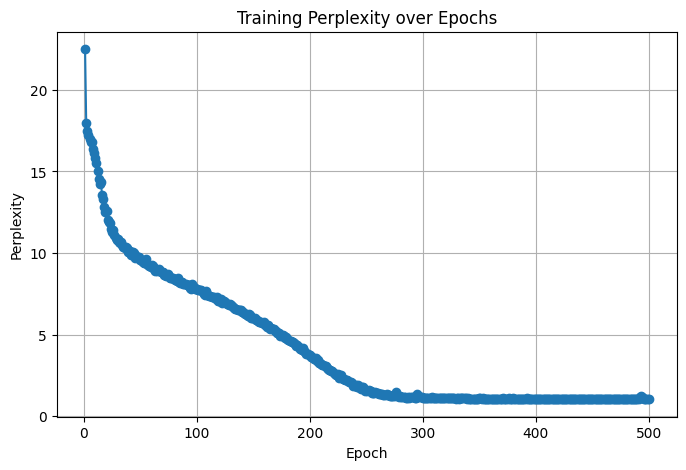

In [10]:
vocab_size, num_hiddens, device = len(vocab), 256, "mps"
num_epochs, lr = 500, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 长短期记忆网络

In [12]:
import torch
from torch import nn

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [13]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

开始在 mps 上训练...
Epoch 10, Perplexity 17.2, Speed 174021.4 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 20, Perplexity 16.2, Speed 160045.7 tokens/sec
  预测 'time traveller': time traveller  t t t t t t t t t t t t t t t t t t t t t t t t 
Epoch 30, Perplexity 14.1, Speed 120974.5 tokens/sec
  预测 'time traveller': time traveller at at at at at at at at at at at at at at at at a
Epoch 40, Perplexity 11.9, Speed 151558.8 tokens/sec
  预测 'time traveller': time travellerethenthenthenthenthenthenthenthenthenthenthenthent
Epoch 50, Perplexity 11.1, Speed 158887.2 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 60, Perplexity 10.5, Speed 141740.6 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 70, Perplexity 10.3, Speed 156865.8 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the

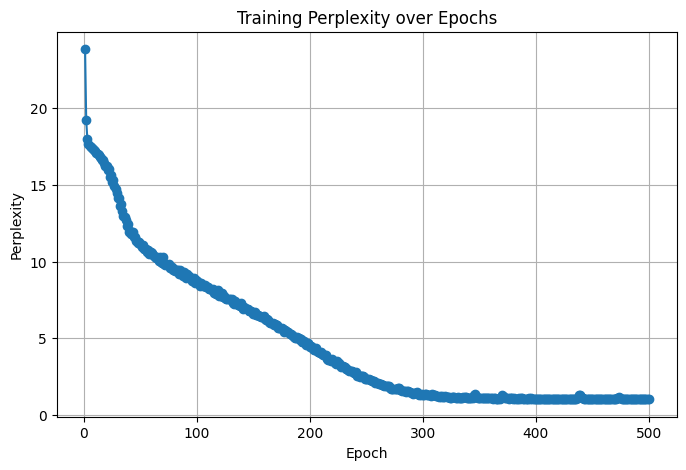

In [14]:
vocab_size, num_hiddens, device = len(vocab), 256, "mps"
num_epochs, lr = 500, 1
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 深度循环神经网络

In [15]:
import torch
from torch import nn

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [16]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = "mps"
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

开始在 mps 上训练...
Epoch 10, Perplexity 17.6, Speed 107962.1 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 20, Perplexity 17.5, Speed 123044.8 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 30, Perplexity 17.2, Speed 113531.5 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 40, Perplexity 15.8, Speed 110994.2 tokens/sec
  预测 'time traveller': time traveller aa ae ae ae ae ae ae ae ae ae ae ae ae ae ae ae a
Epoch 50, Perplexity 14.6, Speed 125433.8 tokens/sec
  预测 'time traveller': time travelleree aan aan aan aan aan aan aan aan aan aan aan aan
Epoch 60, Perplexity 12.1, Speed 126422.9 tokens/sec
  预测 'time traveller': time travellere an an an an an an an an an an an an an an an an 
Epoch 70, Perplexity 11.4, Speed 114262.2 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the

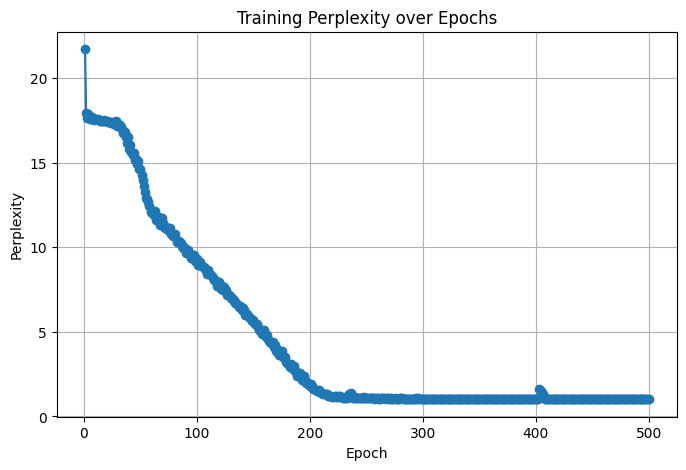

In [17]:
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

# 双向循环网络

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！
开始在 mps 上训练...
Epoch 10, Perplexity 17.4, Speed 57535.1 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 20, Perplexity 17.1, Speed 61271.6 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 30, Perplexity 16.0, Speed 60671.7 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 40, Perplexity 9.6, Speed 61995.5 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 50, Perplexity 4.4, Speed 61554.6 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 60, Perplexity 2.1, Speed 60106.4 tokens/sec
  预测 'time traveller': time travellerererererererererererererererererererererererererer
Epoch 70, Perplexity 1.6, Speed 60881.6 tokens/sec
  预测 'time traveller': time travellererererererer

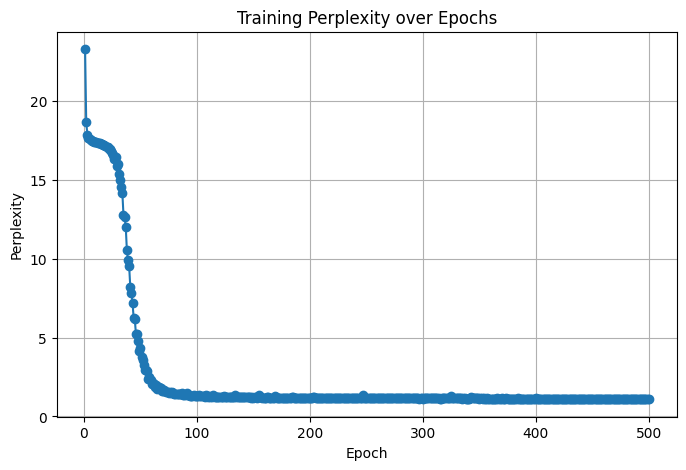

In [19]:
import torch
from torch import nn

# 加载数据
batch_size, num_steps, device = 32, 35, "mps"
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 机器翻译与数据集

In [25]:
import os
import torch

In [26]:
import os
import zipfile
import urllib.request

def read_data_nmt():
    """
    超稳健版：载入“英语－法语”数据集。
    通过在解压前主动检查压缩包内容来精确定位和提取文件。
    """
    # 1. 设置路径
    data_url = 'http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
    data_dir = os.path.join('.', 'data')
    zip_path = os.path.join(data_dir, 'fra-eng.zip')
    # 最终的目标文件路径，我们期望它始终是 ./data/fra.txt
    target_file_path = os.path.join(data_dir, 'fra.txt')

    # 2. 确保数据目录存在
    os.makedirs(data_dir, exist_ok=True)

    # 3. 检查最终文件是否存在
    if not os.path.exists(target_file_path):
        print(f'目标文件 "{target_file_path}" 不存在，开始处理...')

        # 4. 确保zip文件已下载
        if not os.path.exists(zip_path):
            print(f'正在从 {data_url} 下载数据...')
            try:
                urllib.request.urlretrieve(data_url, zip_path)
                print(f'下载完成，文件保存在 "{zip_path}"')
            except Exception as e:
                print(f"下载失败: {e}")
                return None
        
        # 5. [核心修改] 智能检查并解压
        print(f'正在检查压缩包 "{zip_path}" 的内容...')
        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                # 获取zip包内所有文件的列表，用于调试和定位
                file_list = z.namelist()
                print(f'>>> 压缩包中的文件列表: {file_list}')

                # 从列表中寻找我们需要的.txt文件
                txt_file_in_zip = None
                for filename in file_list:
                    if filename.endswith('.txt'):
                        txt_file_in_zip = filename
                        print(f'>>> 在压缩包中找到目标文件: "{txt_file_in_zip}"')
                        break

                if txt_file_in_zip:
                    # 使用 extract 方法精确解压单个文件到 data_dir
                    z.extract(txt_file_in_zip, path=data_dir)
                    
                    # 解压后，文件的实际路径是 os.path.join(data_dir, txt_file_in_zip)
                    # 例如，如果zip包里是 'folder/fra.txt'，这里就会是 './data/folder/fra.txt'
                    extracted_file_actual_path = os.path.join(data_dir, txt_file_in_zip)
                    print(f'>>> 文件已解压到: "{extracted_file_actual_path}"')

                    # [重要] 如果解压后的路径不是我们期望的最终路径，就重命名/移动它
                    if os.path.normpath(extracted_file_actual_path) != os.path.normpath(target_file_path):
                        print(f'>>> 调整文件位置: 从 "{extracted_file_actual_path}" 移动到 "{target_file_path}"')
                        os.rename(extracted_file_actual_path, target_file_path)
                    print('>>> 文件已就绪。')
                else:
                    print("错误：在压缩包中未找到任何 .txt 文件。")
                    return None
        except Exception as e:
            print(f"处理压缩包时出错: {e}")
            return None
    else:
        print(f'文件 "{target_file_path}" 已存在，直接读取。')

    # 6. 读取文件
    try:
        with open(target_file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"最终读取失败，文件 '{target_file_path}' 仍不存在。脚本无法自动解决此问题。")
        return None

# --- 执行代码 ---
raw_text = read_data_nmt()

if raw_text:
    print("\n--- 数据内容预览 ---")
    print(raw_text[:75])

文件 "./data/fra.txt" 已存在，直接读取。

--- 数据内容预览 ---
Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [27]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

# go .	va !
# hi .	salut !
# run !	cours !
# run !	courez !
# who ?	qui ?
# wow !	ça alors !

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [28]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

# ([['go', '.'],
#   ['hi', '.'],
#   ['run', '!'],
#   ['run', '!'],
#   ['who', '?'],
#   ['wow', '!']],
#  [['va', '!'],
#   ['salut', '!'],
#   ['cours', '!'],
#   ['courez', '!'],
#   ['qui', '?'],
#   ['ça', 'alors', '!']])

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

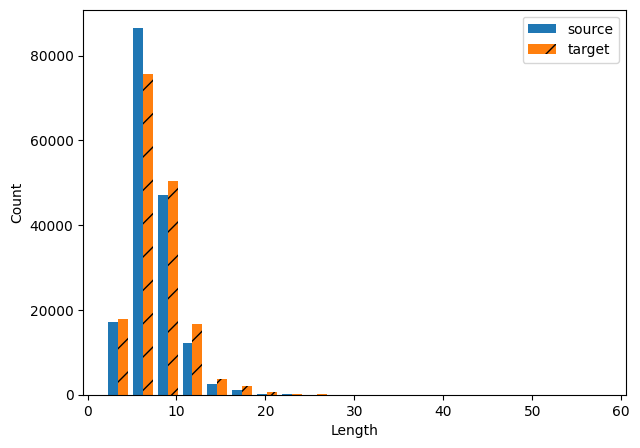

In [29]:
import matplotlib.pyplot as plt
from typing import List

def show_list_len_pair_hist(legend: List[str], 
                            xlabel: str, 
                            ylabel: str, 
                            xlist: List[List], 
                            ylist: List[List]):
    """
    绘制列表长度对的直方图 (不依赖d2l包)。
    :param legend: 图例，一个包含两个字符串的列表，例如 ['source', 'target']。
    :param xlabel: x轴标签。
    :param ylabel: y轴标签。
    :param xlist: 第一个数据列表 (例如 source)。
    :param ylist: 第二个数据列表 (例如 target)。
    """
    # 1. 设置图像大小
    plt.figure(figsize=(7, 5))

    # 2. 准备用于直方图的数据：计算每个序列的长度
    x_lengths = [len(l) for l in xlist]
    y_lengths = [len(l) for l in ylist]

    # 3. 绘制直方图
    # plt.hist 可以直接接收一个包含两个数据列表的列表
    # label参数用于后续生成图例
    _, _, patches = plt.hist(
        [x_lengths, y_lengths], 
        label=legend, 
        bins=20  # 可以指定条柱的数量以获得更平滑的视图
    )

    # 4. 设置x轴和y轴的标签
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # 5. 为第二个直方图的条柱添加斜线填充，以作区分
    # 这部分逻辑与d2l无关，可以直接保留
    for patch in patches[1].patches:
        patch.set_hatch('/')

    # 6. 显示图例
    plt.legend()

    # 7. 显示图像
    plt.show()

# 使用自定义函数绘制源语言和目标语言的长度分布直方图
show_list_len_pair_hist(
    legend=['source', 'target'],
    xlabel='Length',
    ylabel='Count',
    xlist=source,
    ylist=target
)

In [30]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [31]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [32]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [33]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # 使用 PyTorch 的 DataLoader 替代 d2l.load_array
    from torch.utils.data import DataLoader, TensorDataset
    dataset = TensorDataset(*data_arrays)
    data_iter = DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, src_vocab, tgt_vocab

In [34]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

# 文件 "./data/fra.txt" 已存在，直接读取。
# X: tensor([[ 17,  20,   4,   3,   1,   1,   1,   1],
#         [130,  23,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
# X的有效长度: tensor([4, 4])
# Y: tensor([[ 11,   0,   4,   3,   1,   1,   1,   1],
#         [139,  15,  11,   4,   3,   1,   1,   1]], dtype=torch.int32)
# Y的有效长度: tensor([4, 5])

文件 "./data/fra.txt" 已存在，直接读取。
X: tensor([[  6,  92,  29,   4,   3,   1,   1,   1],
        [  7, 154,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([5, 4])
Y: tensor([[ 6, 42, 19,  0,  4,  3,  1,  1],
        [ 6,  7,  0,  4,  3,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([6, 5])


# 编码器-解码器架构

In [1]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [2]:
#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [3]:
#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# 序列到序列学习

In [4]:
import collections
import math
import torch
from torch import nn

In [6]:
#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

# torch.Size([7, 4, 16])

torch.Size([7, 4, 16])

In [ ]:
state.shape

# torch.Size([2, 4, 16])

torch.Size([2, 4, 16])

In [9]:
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

# (torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [ ]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

# tensor([[1, 0, 0],
#         [4, 5, 0]])

tensor([[1, 0, 0],
        [4, 5, 0]])

In [ ]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

# tensor([[[ 1.,  1.,  1.,  1.],
#          [-1., -1., -1., -1.],
#          [-1., -1., -1., -1.]],

#         [[ 1.,  1.,  1.,  1.],
#          [ 1.,  1.,  1.,  1.],
#          [-1., -1., -1., -1.]]])

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [13]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

# tensor([2.3026, 1.1513, 0.0000])

tensor([2.3026, 1.1513, 0.0000])

In [38]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型 (不依赖d2l包)"""
    import time
    
    # --- 1. 初始化 ---
    
    # 定义权重初始化函数
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    
    # 用于存储每个epoch的损失，以便后续绘图
    epoch_losses = []
    
    print("开始训练...")
    for epoch in range(num_epochs):
        # --- 2. 训练一个 Epoch ---
        start_time = time.time()
        # 替代 d2l.Accumulator
        total_loss = 0
        total_tokens = 0
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            # 准备解码器的输入（强制教学）
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            
            # 前向传播
            Y_hat, _ = net(X, dec_input, X_valid_len)
            
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            l = l.sum()
            
            # 反向传播
            l.backward()
            
            # 梯度裁剪 (替代 d2l.grad_clipping)
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            
            # 累加损失和词元数
            total_loss += l.item()
            total_tokens += num_tokens.item()

        # --- 3. 记录和打印 Epoch 信息 ---
        duration = time.time() - start_time
        avg_loss = total_loss / total_tokens
        epoch_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Loss: {avg_loss:.3f}, '
                  f'{total_tokens / duration:.1f} tokens/sec on {str(device)}')

    print("训练完成。")

    # --- 4. 训练后绘图 ---
    print("绘制损失曲线...")
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.title('Training Loss Curve')
    plt.show()

文件 "./data/fra.txt" 已存在，直接读取。
开始训练...
Epoch 10/300, Loss: 0.204, 5480.5 tokens/sec on mps
Epoch 20/300, Loss: 0.147, 5598.6 tokens/sec on mps
Epoch 30/300, Loss: 0.112, 5067.5 tokens/sec on mps
Epoch 40/300, Loss: 0.091, 5301.2 tokens/sec on mps
Epoch 50/300, Loss: 0.074, 4851.6 tokens/sec on mps
Epoch 60/300, Loss: 0.063, 5300.0 tokens/sec on mps
Epoch 70/300, Loss: 0.055, 5386.0 tokens/sec on mps
Epoch 80/300, Loss: 0.048, 5526.4 tokens/sec on mps
Epoch 90/300, Loss: 0.044, 5634.1 tokens/sec on mps
Epoch 100/300, Loss: 0.039, 4433.2 tokens/sec on mps
Epoch 110/300, Loss: 0.035, 5282.3 tokens/sec on mps
Epoch 120/300, Loss: 0.032, 4748.9 tokens/sec on mps
Epoch 130/300, Loss: 0.031, 5384.2 tokens/sec on mps
Epoch 140/300, Loss: 0.029, 5429.5 tokens/sec on mps
Epoch 150/300, Loss: 0.027, 5202.1 tokens/sec on mps
Epoch 160/300, Loss: 0.026, 3749.7 tokens/sec on mps
Epoch 170/300, Loss: 0.026, 3357.1 tokens/sec on mps
Epoch 180/300, Loss: 0.025, 3856.6 tokens/sec on mps
Epoch 190/300, Lo

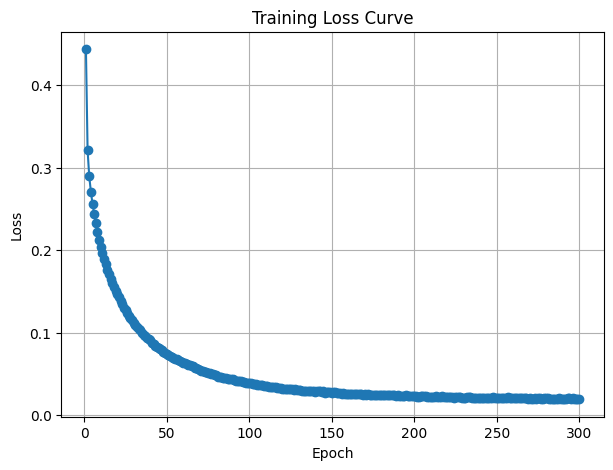

In [39]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, "mps"

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [41]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充


#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [42]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [43]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il court ., bleu 0.000
i'm home . => je suis chez moi bien !, bleu 0.719
